In [246]:
import datetime
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import tensorflow as tf

In [247]:
def load_and_concatenate_data(folder_path):
    # List to hold individual dataframes
    data_frames = []
    
    # Loop through all files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith("_pfr_fantasy.csv"):
            # Extract year from file name
            year_suffix = int(file_name[:2])
            
            # Determine the full year
            if year_suffix < 24:
                year = 2000 + year_suffix
            else:
                year = 1900 + year_suffix
            
            # Construct full file path
            file_path = os.path.join(folder_path, file_name)
            
            # Read the CSV file into a DataFrame
            df = pd.read_csv(file_path)
            
            # Add a 'year' column
            df['Year'] = year
            
            # Append the DataFrame to the list
            data_frames.append(df)
    
    # Concatenate all DataFrames
    combined_df = pd.concat(data_frames, ignore_index=True)
    return combined_df


In [248]:
def preprocess_data(df):
    # Define numerical and categorical columns
    numerical_cols = [
        'Age', 'G-Games', 'GS-Games', 'Cmp-Passing', 'Att-Passing', 'Yds-Passing', 
        'TD-Passing', 'Int-Passing', 'Att-Rushing', 'Yds-Rushing', 'Y/A-Rushing', 
        'TD-Rushing', 'Tgt-Receiving', 'Rec-Receiving', 'Yds-Receiving', 
        'Y/R-Receiving', 'TD-Receiving', 'Fmb-Fumbles', 'FL-Fumbles', 
        'TD-Scoring', '2PM-Scoring', '2PP-Scoring'
    ]
    categorical_cols = ['FantPos', 'Tm']
    
    # Preprocessing for numerical data: Fill missing values with zero and standardize
    numerical_transformer = Pipeline(steps=[
        ('fillna', SimpleImputer(strategy='constant', fill_value=0)),
        ('scaler', StandardScaler())
    ])
    
    # Preprocessing for categorical data: Fill missing values with a placeholder and one-hot encode
    categorical_transformer = Pipeline(steps=[
        ('fillna', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    # Combine preprocessing steps
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])
    
    # Fit and transform the data
    df_preprocessed = preprocessor.fit_transform(df)
    
    # Convert to DataFrame
    df_preprocessed = pd.DataFrame(
        df_preprocessed, 
        columns=numerical_cols + list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols))
    )
    
    # Add back non-transformed columns
    df_preprocessed['Year'] = df['Year'].values
    df_preprocessed['Player'] = df['Player'].values
    df_preprocessed['PlayerCode'] = df['PlayerCode'].values
    df_preprocessed['Rk'] = df['Rk'].values
    
    return df_preprocessed, preprocessor


In [249]:
def create_sequences_and_targets(df, target_columns, sequence_length):
    # Sort data by PlayerCode and Year to ensure chronological order
    df_sorted = df.sort_values(by=['PlayerCode', 'Year'])
    
    sequences = []
    targets = []
    player_codes = df_sorted['PlayerCode'].unique()
    
    for player_code in player_codes:
        player_data = df_sorted[df_sorted['PlayerCode'] == player_code]
        
        # Ensure we have enough data to create at least one sequence
        if len(player_data) <= sequence_length:
            continue
        
        # Create sequences and corresponding targets
        for i in range(len(player_data) - sequence_length):
            X_seq = player_data.iloc[i:i+sequence_length].drop(columns=['Year', 'Player', 'PlayerCode', 'Rk'] + target_columns).values
            y_target = player_data.iloc[i+sequence_length][target_columns].values
            
            sequences.append(X_seq)
            targets.append(y_target)
    
    # Pad sequences to have the same length
    sequences_padded = pad_sequences(sequences, padding='post', dtype='float32')
    targets = np.array(targets, dtype='float32')
    
    return np.array(sequences_padded), targets


In [250]:
def create_loocv_datasets(sequences, targets):
    datasets = []
    num_samples = len(sequences)
    
    for i in range(num_samples):
        # Create test set using the i-th sample's sequence
        X_test = sequences[i]
        y_test = targets[i]
        
        # Expand dims to ensure the correct shape (1, sequence_length, num_features)
        X_test = np.expand_dims(X_test, axis=0)
        y_test = np.expand_dims(y_test, axis=0)
        
        # Create training set using all other samples' sequences
        X_train = np.delete(sequences, i, axis=0)
        y_train = np.delete(targets, i, axis=0)
        
        # Shuffle the training set
        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        X_train = X_train[indices]
        y_train = y_train[indices]
        
        # Create TensorFlow datasets
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=len(X_train)).batch(32)
        test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(1)
        
        datasets.append((train_dataset, test_dataset))
    
    return datasets

In [251]:
def get_data_subset(df, percentage=0.1):
    """
    Get a subset of the data by sampling a percentage of players.
    """
    player_codes = df['PlayerCode'].unique()
    subset_player_codes = np.random.choice(player_codes, size=int(len(player_codes) * percentage), replace=False)
    subset_df = df[df['PlayerCode'].isin(subset_player_codes)]
    return subset_df

# Use a subset of the data for initial training
combined_df_subset = get_data_subset(combined_df, percentage=0.1)


In [252]:
def create_sequences_and_targets_full_length(df, target_columns):
    df_sorted = df.sort_values(by=['PlayerCode', 'Year'])
    
    sequences = []
    targets = []
    years = []
    player_codes = df_sorted['PlayerCode'].unique()
    
    for player_code in player_codes:
        player_data = df_sorted[df_sorted['PlayerCode'] == player_code]
        if len(player_data) < 2:  # Need at least two years of data to create a sequence
            continue
        
        for i in range(len(player_data) - 1):
            X_seq = player_data.iloc[:i+1].drop(columns=['Year', 'Player', 'PlayerCode', 'Rk'] + target_columns).values
            y_target = player_data.iloc[i+1][target_columns].values
            year = player_data.iloc[i+1]['Year']
            
            sequences.append(X_seq)
            targets.append(y_target)
            years.append(year)
    
    if len(sequences) == 0:
        raise ValueError("No sequences were created. Check your data filtering conditions.")
    
    sequences_padded = pad_sequences(sequences, padding='post', dtype='float32')
    targets = np.array(targets, dtype='float32')
    years = np.array(years, dtype='int32')
    
    return sequences_padded, targets, years


In [253]:
def create_kfold_datasets(sequences, targets, max_splits=5):
    n_splits = min(max_splits, len(sequences))
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    datasets = []
    
    for train_index, test_index in kf.split(sequences):
        X_train, X_test = sequences[train_index], sequences[test_index]
        y_train, y_test = targets[train_index], targets[test_index]
        
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=len(X_train)).batch(32)
        test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(1)
        
        datasets.append((train_dataset, test_dataset))
    
    return datasets


In [254]:
def create_simple_model(input_shape, num_targets):
    model = tf.keras.Sequential([
    tf.keras.layers.Masking(mask_value=0.0, input_shape=(sequence_length, sequences.shape[-1])),
    tf.keras.layers.Conv1D(filters=32, kernel_size=2, activation='relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(targets.shape[-1])
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss='mse')
    return model


In [255]:
def check_for_gpu():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
            tf.config.experimental.set_virtual_device_configuration(
                gpus[0],
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            print(e)
        return True
    else:
        return False

In [256]:
# plot the training data from our model 
def plot_training_history(history):
    loss = history.history['loss']
    try:
        val_loss = history.history['val_loss']
        vd = True
    except(KeyError):
        vd = False
    epochs = range(1,len(loss)+1)

    plt.figure()
    plt.plot(epochs, loss, linewidth=1.5, label='Training loss')
    if vd:
        plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [257]:
# try: 
#     folder_path = '/Users/harrisonward/Desktop/CS/Git/final_fantasy/data'
# except FileNotFoundError:
#     os.makedirs('/content/data')
#     folder_path ='/content/data'

In [258]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
import datetime

def load_and_concatenate_data(folder_path):
    all_files = os.listdir(folder_path)
    csv_files = [f for f in all_files if f.endswith('.csv')]
    
    combined_df = pd.DataFrame()
    
    for file in csv_files:
        year = int(file.split('_')[0])
        if year < 24:
            year = 2000 + year
        else:
            year = 1900 + year
        
        df = pd.read_csv(os.path.join(folder_path, file))
        df['Year'] = year
        combined_df = pd.concat([combined_df, df], ignore_index=True)
    
    return combined_df

def preprocess_data(df):
    df = df.fillna(0)
    categorical_columns = ['Player', 'Tm', 'FantPos']
    df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
    
    scaler = StandardScaler()
    df[df.columns.difference(['Year', 'Player', 'PlayerCode', 'Rk'])] = scaler.fit_transform(df[df.columns.difference(['Year', 'Player', 'PlayerCode', 'Rk'])])
    
    return df, scaler

def get_data_subset(df, percentage=0.1):
    player_codes = df['PlayerCode'].unique()
    subset_player_codes = np.random.choice(player_codes, size=int(len(player_codes) * percentage), replace=False)
    subset_df = df[df['PlayerCode'].isin(subset_player_codes)]
    return subset_df

def create_sequences_and_targets_full_length(df, target_columns):
    df_sorted = df.sort_values(by=['PlayerCode', 'Year'])
    
    sequences = []
    targets = []
    years = []
    player_codes = df_sorted['PlayerCode'].unique()
    
    for player_code in player_codes:
        player_data = df_sorted[df_sorted['PlayerCode'] == player_code]
        if len(player_data) < 2:  # Need at least two years of data to create a sequence
            continue
        
        for i in range(len(player_data) - 1):
            X_seq = player_data.iloc[:i+1].drop(columns=['Year', 'Player', 'PlayerCode', 'Rk'] + target_columns).values
            y_target = player_data.iloc[i+1][target_columns].values
            year = player_data.iloc[i+1]['Year']
            
            sequences.append(X_seq)
            targets.append(y_target)
            years.append(year)
    
    if len(sequences) == 0:
        raise ValueError("No sequences were created. Check your data filtering conditions.")
    
    sequences_padded = pad_sequences(sequences, padding='post', dtype='float32')
    targets = np.array(targets, dtype='float32')
    years = np.array(years, dtype='int32')
    
    return sequences_padded, targets, years

def normalize_targets(targets, scaler):
    targets = scaler.fit_transform(targets)
    return targets

def create_simple_model(input_shape, num_targets):
    model = tf.keras.Sequential([
        tf.keras.layers.Masking(mask_value=0.0, input_shape=input_shape),
        tf.keras.layers.LSTM(32, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(num_targets)
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=optimizer, loss='mse')
    return model

def check_for_gpu():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            tf.config.experimental.set_virtual_device_configuration(
                gpus[0],
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        except RuntimeError as e:
            print(e)
        return True
    else:
        return False


In [259]:
# Load and concatenate data
folder_path = '/Users/harrisonward/Desktop/CS/Git/final_fantasy/data'
combined_df = load_and_concatenate_data(folder_path)

# Sample a subset of players
combined_df_subset = get_data_subset(combined_df, percentage=0.4)

# Ensure there are enough rows in the subset
if combined_df_subset.shape[0] == 0:
    raise ValueError("No data available after sampling. Check the sampling percentage and data conditions.")

# Preprocess the data
df_preprocessed, preprocessor = preprocess_data(combined_df_subset)

# Add the Year, Player, PlayerCode, and Rk columns back to the preprocessed DataFrame
df_preprocessed['Year'] = combined_df_subset['Year']
df_preprocessed['Player'] = combined_df_subset['Player']
df_preprocessed['PlayerCode'] = combined_df_subset['PlayerCode']
df_preprocessed['Rk'] = combined_df_subset['Rk']

# Ensure there are enough rows in the preprocessed data
if df_preprocessed.shape[0] == 0:
    raise ValueError("No data available after preprocessing. Check the preprocessing steps.")

# Create sequences and targets without capping sequence length
target_columns = ['Yds-Passing', 'TD-Passing', 'Int-Passing', 'Yds-Rushing', 'TD-Rushing', 
                  'Tgt-Receiving', 'Rec-Receiving', 'Yds-Receiving', 'TD-Receiving', 'Fmb-Fumbles']
sequences, targets, years = create_sequences_and_targets_full_length(df_preprocessed, target_columns)

# Normalize the targets
targets = normalize_targets(targets, preprocessor)

# Check for GPU and set mixed precision if available
if check_for_gpu():
    tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Define model parameters
input_shape = sequences.shape[1:]
num_targets = targets.shape[-1]

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Ensure directory for checkpoints exists
os.makedirs("training_checkpoints", exist_ok=True)
checkpoint_path = "training_checkpoints/cp-{epoch:04d}.ckpt"
model_checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                   save_weights_only=True,
                                   monitor='val_loss',
                                   mode='min',
                                   save_best_only=True)

# Split data into training and validation sets
split_ratio = 0.8
split_index = int(len(sequences) * split_ratio)
X_train, X_val = sequences[:split_index], sequences[split_index:]
y_train, y_val = targets[:split_index], targets[split_index:]

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(buffer_size=len(X_train)).batch(64)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64)

# Define and compile the model
model = create_simple_model(input_shape, num_targets)

# Train the model
history = model.fit(train_dataset, epochs=20, verbose=1, validation_data=val_dataset, 
                    callbacks=[early_stopping, tensorboard_callback, model_checkpoint])

# Check if any checkpoints were saved
checkpoint_dir = os.path.dirname(checkpoint_path)
latest = tf.train.latest_checkpoint(checkpoint_dir)
if latest:
    # Load the best model weights
    model.load_weights(latest)

    # Evaluate the model on the validation set
    val_loss = model.evaluate(val_dataset)
    print(f'Validation Loss: {val_loss}')
else:
    print("No checkpoints found.")

# Load the TensorBoard notebook extension
%load_ext tensorboard

# Start TensorBoard
%tensorboard --logdir logs/fit --load_fast true


/var/folders/b7/9xtmcnvx6glcms00_g_hs57h0000gn/T/ipykernel_59552/3872634634.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_preprocessed['Player'] = combined_df_subset['Player']


Epoch 1/20
74/74 [==============================] - 95s 1s/step - loss: 0.9782 - val_loss: 0.6923
Epoch 2/20
74/74 [==============================] - 104s 1s/step - loss: 0.6087 - val_loss: 0.6337
Epoch 3/20
74/74 [==============================] - 120s 2s/step - loss: 0.4483 - val_loss: 0.6040
Epoch 4/20
74/74 [==============================] - 95s 1s/step - loss: 0.3658 - val_loss: 0.5917
Epoch 5/20
74/74 [==============================] - 83s 1s/step - loss: 0.3146 - val_loss: 0.5824
Epoch 6/20
74/74 [==============================] - 89s 1s/step - loss: 0.2834 - val_loss: 0.5745
Epoch 7/20
74/74 [==============================] - 79s 1s/step - loss: 0.2614 - val_loss: 0.5745
Epoch 8/20
74/74 [==============================] - 97s 1s/step - loss: 0.2393 - val_loss: 0.5747
Epoch 9/20
19/19 [==============================] - 10s 510ms/step - loss: 0.5745
Validation Loss: 0.5744953751564026
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/cs109b/bin/tensorboard", line 5, in <module>
    from tensorboard.main import run_main
  File "/opt/anaconda3/envs/cs109b/lib/python3.9/site-packages/tensorboard/main.py", line 27, in <module>
    from tensorboard import default
  File "/opt/anaconda3/envs/cs109b/lib/python3.9/site-packages/tensorboard/default.py", line 32, in <module>
    from tensorboard.plugins.audio import audio_plugin
  File "/opt/anaconda3/envs/cs109b/lib/python3.9/site-packages/tensorboard/plugins/audio/audio_plugin.py", line 27, in <module>
    from tensorboard.plugins.audio import metadata
  File "/opt/anaconda3/envs/cs109b/lib/python3.9/site-packages/tensorboard/plugins/audio/metadata.py", line 18, in <module>
    from tensorboard.compat.proto import summary_pb2
  File "/opt/anaconda3/envs/cs109b/lib/python3.9/site-packages/tensorboard/compat/proto/summary_pb2.py", line 6, in

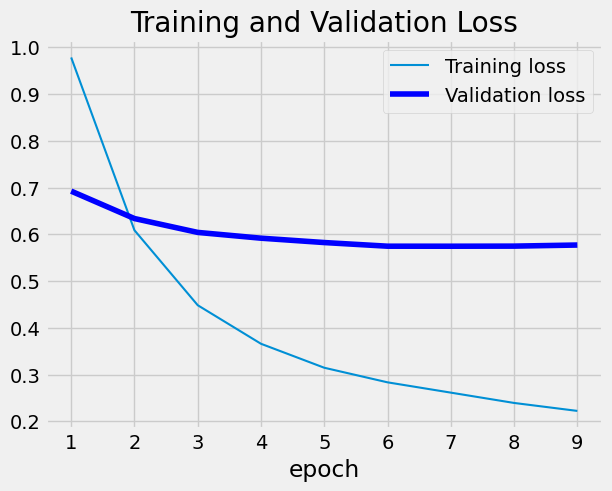

In [260]:
plt.style.use('fivethirtyeight')
plot_training_history(history)